Clear sky
=========

This section reviews the clear sky modeling capabilities of
pvlib-python.

pvlib-python supports two ways to generate clear sky irradiance:

1. A :py:class:`~pvlib.location.Location` object's
   :py:meth:`~pvlib.location.Location.get_clearsky` method.
2. The functions contained in the :py:mod:`~pvlib.clearsky` module,
   including :py:func:`~pvlib.clearsky.ineichen` and
   :py:func:`~pvlib.clearsky.simplified_solis`.

Users that work with simple time series data may prefer to use
:py:meth:`~pvlib.location.Location.get_clearsky`, while users
that want finer control, more explicit code, or work with
multidimensional data may prefer to use the basic functions in the
:py:mod:`~pvlib.clearsky` module.

The :ref:`location` subsection demonstrates the easiest way to obtain a
time series of clear sky data for a location. The :ref:`ineichen` and
:ref:`simplified_solis` subsections detail the clear sky algorithms and
input data. The :ref:`detect_clearsky` subsection demonstrates the use
of the clear sky detection algorithm.

We'll need these imports for the examples below.

In [1]:
import os

import itertools

import matplotlib.pyplot as plt

import pandas as pd

import pvlib

from pvlib import clearsky, atmosphere, solarposition

from pvlib.location import Location

from pvlib.iotools import read_tmy3

Location
--------

The easiest way to obtain a time series of clear sky irradiance is to use a
:py:class:`~pvlib.location.Location` object's
:py:meth:`~pvlib.location.Location.get_clearsky` method. The
:py:meth:`~pvlib.location.Location.get_clearsky` method does the dirty
work of calculating solar position, extraterrestrial irradiance,
airmass, and atmospheric pressure, as appropriate, leaving the user to
only specify the most important parameters: time and atmospheric
attenuation. The time input must be a :py:class:`pandas.DatetimeIndex`,
while the atmospheric attenuation inputs may be constants or arrays.
The :py:meth:`~pvlib.location.Location.get_clearsky` method always
returns a :py:class:`pandas.DataFrame`.

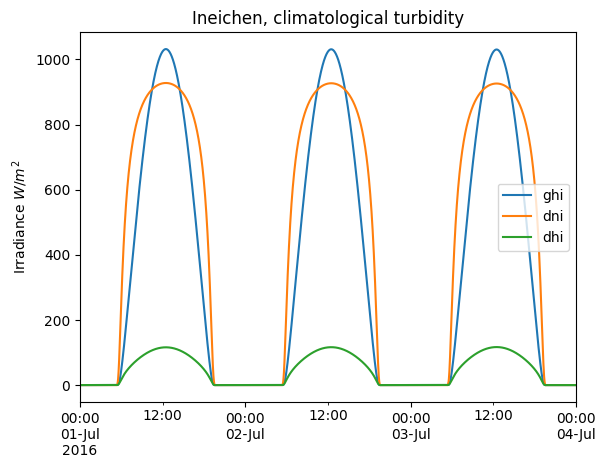

In [2]:
tus = Location(32.2, -111, 'US/Arizona', 700, 'Tucson')

times = pd.date_range(start='2016-07-01', end='2016-07-04', freq='1min', tz=tus.tz)

cs = tus.get_clearsky(times)  # ineichen with climatology table by default

cs.plot();

plt.ylabel('Irradiance $W/m^2$');

plt.title('Ineichen, climatological turbidity');

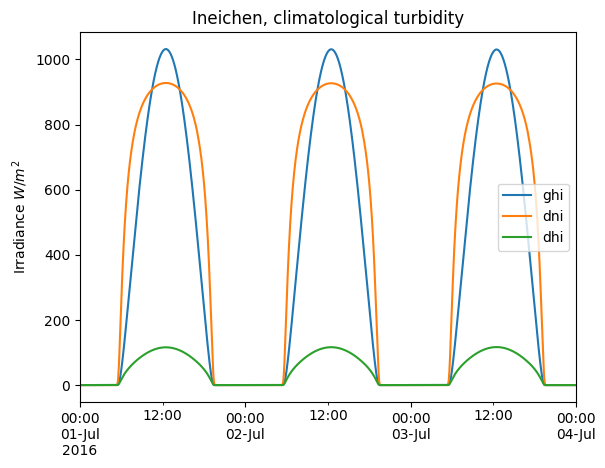

In [3]:
tus = Location(32.2, -111, 'US/Arizona', 700, 'Tucson')

times = pd.date_range(start='2016-07-01', end='2016-07-04', freq='1min', tz=tus.tz)

# cs = tus.get_clearsky(times)  # ineichen with climatology table by default
cs_utc = tus.get_clearsky(times.tz_convert('utc')).tz_convert(tus.tz)  # ineichen with climatology table by default

# cs.plot()
cs_utc.plot();

plt.ylabel('Irradiance $W/m^2$');

plt.title('Ineichen, climatological turbidity');

In [4]:
assert cs.index.equals(cs_utc.index)
assert not ((cs < 0).any().any() or (cs_utc < 0).any().any())
print(len(cs))
df = cs.join(cs_utc, how = 'outer', rsuffix = '_utc')[~ cs.fillna(-1).eq(cs_utc.fillna(-1)).all(axis = 'columns')]
print(df.index.hour.unique(), df.index.minute.nunique())
df

4321
Index([17, 18, 19], dtype='int32') 60


,ghi,dni,dhi,ghi_utc,dni_utc,dhi_utc
2016-07-01 17:00:00-07:00,460.378093,778.936621,70.469943,460.055525,777.658658,70.787077
2016-07-01 17:01:00-07:00,456.733517,777.196738,70.143925,456.411549,775.913720,70.460150
2016-07-01 17:02:00-07:00,453.083990,775.435849,69.816605,452.762630,774.147732,70.131910
2016-07-01 17:03:00-07:00,449.429616,773.653621,69.487974,449.108869,772.360361,69.802348
2016-07-01 17:04:00-07:00,445.770496,771.849713,69.158023,445.450370,770.551267,69.471455
...,...,...,...,...,...,...
2016-07-03 19:28:00-07:00,0.372376,6.479330,0.286308,0.368759,6.330446,0.284669
2016-07-03 19:29:00-07:00,0.232132,4.744294,0.182824,0.229742,4.628755,0.181634
2016-07-03 19:30:00-07:00,0.131663,3.388042,0.106134,0.130224,3.300508,0.105355
2016-07-03 19:31:00-07:00,0.063133,2.356295,0.052039,0.062400,2.291654,0.051610


The :py:meth:`~pvlib.location.Location.get_clearsky` method accepts a
model keyword argument and propagates additional arguments to the
functions that do the computation.

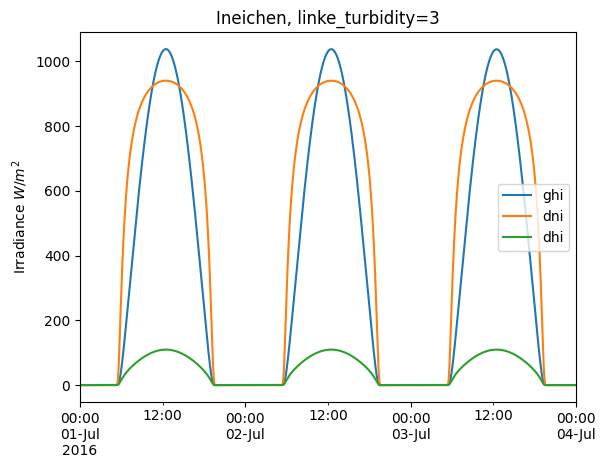

In [5]:
cs = tus.get_clearsky(times, model='ineichen', linke_turbidity=3)

cs.plot();

plt.title('Ineichen, linke_turbidity=3');

plt.ylabel('Irradiance $W/m^2$');

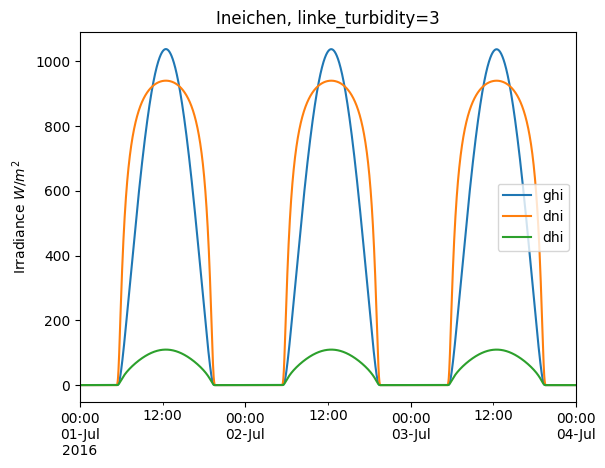

In [6]:
# cs = tus.get_clearsky(times, model='ineichen', linke_turbidity=3)
cs_utc = tus.get_clearsky(times.tz_convert('utc'), model='ineichen', linke_turbidity=3).tz_convert(tus.tz)

# cs.plot();
cs_utc.plot();

plt.title('Ineichen, linke_turbidity=3');

plt.ylabel('Irradiance $W/m^2$');

In [7]:
assert cs.index.equals(cs_utc.index)
assert not ((cs < 0).any().any() or (cs_utc < 0).any().any())
print(len(cs))
df = cs.join(cs_utc, how = 'outer', rsuffix = '_utc')[~ cs.fillna(-1).eq(cs_utc.fillna(-1)).all(axis = 'columns')]
print(df.index.hour.unique(), df.index.minute.nunique())
df

4321
Index([17, 18, 19], dtype='int32') 60


,ghi,dni,dhi,ghi_utc,dni_utc,dhi_utc
2016-07-01 17:00:00-07:00,465.420700,799.415471,65.261561,465.411367,799.399441,65.260252
2016-07-01 17:01:00-07:00,461.767823,797.759969,64.949765,461.758563,797.743972,64.948462
2016-07-01 17:02:00-07:00,458.109888,796.084204,64.636835,458.100702,796.068241,64.635539
2016-07-01 17:03:00-07:00,454.446997,794.387849,64.322767,454.437884,794.371919,64.321477
2016-07-01 17:04:00-07:00,450.779249,792.670567,64.007553,450.770210,792.654672,64.006269
...,...,...,...,...,...,...
2016-07-03 19:28:00-07:00,0.443876,9.845733,0.313091,0.443876,9.845725,0.313091
2016-07-03 19:29:00-07:00,0.279664,7.394309,0.202814,0.279664,7.394302,0.202814
2016-07-03 19:30:00-07:00,0.160456,5.427082,0.119563,0.160456,5.427078,0.119563
2016-07-03 19:31:00-07:00,0.077899,3.887530,0.059596,0.077899,3.887527,0.059596


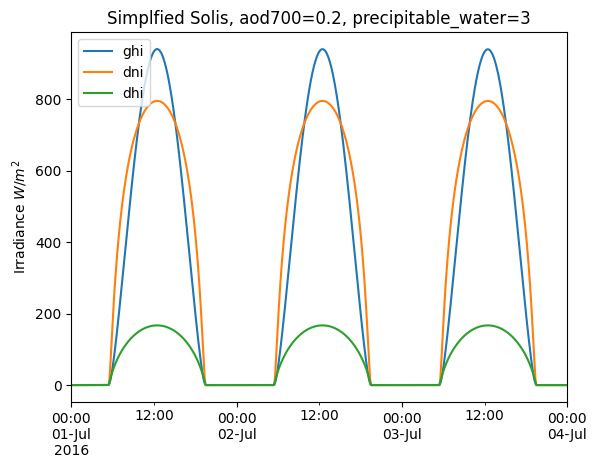

In [8]:
cs = tus.get_clearsky(times, model='simplified_solis', aod700=0.2, precipitable_water=3)

cs.plot();

plt.title('Simplfied Solis, aod700=0.2, precipitable_water=3');

plt.ylabel('Irradiance $W/m^2$');

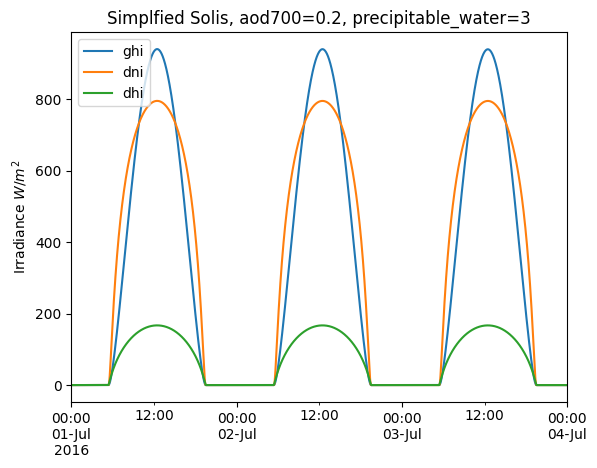

In [9]:
# cs = tus.get_clearsky(times, model='simplified_solis', aod700=0.2, precipitable_water=3)
cs_utc = tus.get_clearsky(times.tz_convert('utc'), model='simplified_solis', aod700=0.2, precipitable_water=3).tz_convert(tus.tz)

# cs.plot();
cs_utc.plot();

plt.title('Simplfied Solis, aod700=0.2, precipitable_water=3');

plt.ylabel('Irradiance $W/m^2$');

In [10]:
assert cs.index.equals(cs_utc.index)
assert not ((cs < 0).any().any() or (cs_utc < 0).any().any())
print(len(cs))
df = cs.join(cs_utc, how = 'outer', rsuffix = '_utc')[~ cs.fillna(-1).eq(cs_utc.fillna(-1)).all(axis = 'columns')]
print(df.index.hour.unique(), df.index.minute.nunique())
df

4321
Index([17, 18, 19], dtype='int32') 60


,ghi,dni,dhi,ghi_utc,dni_utc,dhi_utc
2016-07-01 17:00:00-07:00,396.328080,580.273573,113.580288,396.320132,580.261937,113.578011
2016-07-01 17:01:00-07:00,393.056914,578.257168,113.140595,393.049032,578.245573,113.138326
2016-07-01 17:02:00-07:00,389.784574,576.224964,112.698430,389.776758,576.213410,112.696170
2016-07-01 17:03:00-07:00,386.511183,574.176806,112.253778,386.503432,574.165292,112.251527
2016-07-01 17:04:00-07:00,383.236862,572.112534,111.806623,383.229177,572.101062,111.804381
...,...,...,...,...,...,...
2016-07-03 19:28:00-07:00,0.777317,1.736717,3.572273,0.777316,1.736716,3.572270
2016-07-03 19:29:00-07:00,0.426368,0.691546,2.510011,0.426367,0.691545,2.510008
2016-07-03 19:30:00-07:00,0.183262,0.171250,1.532614,0.183262,0.171250,1.532613
2016-07-03 19:31:00-07:00,0.046592,0.014027,0.696068,0.046592,0.014027,0.696068


See the sections below for more detail on the clear sky models.

Ineichen and Perez
------------------

The Ineichen and Perez clear sky model parameterizes irradiance in terms
of the Linke turbidity [Ine02]_. pvlib-python implements this model in
the :py:func:`pvlib.clearsky.ineichen` function.

Turbidity data
^^^^^^^^^^^^^^

pvlib includes a file with monthly climatological turbidity values for
the globe. The code below creates turbidity maps for a few months of
the year. You could run it in a loop to create plots for all months.

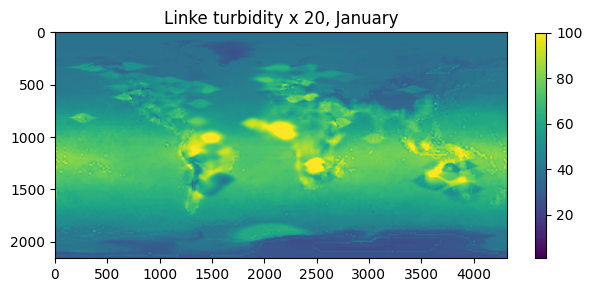

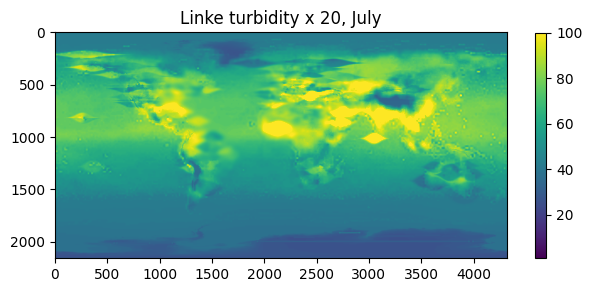

In [11]:
import calendar

import os

import h5py

pvlib_path = os.path.dirname(os.path.abspath(pvlib.clearsky.__file__))

filepath = os.path.join(pvlib_path, 'data', 'LinkeTurbidities.h5')

def plot_turbidity_map(month, vmin=1, vmax=100):
    plt.figure();
    with h5py.File(filepath, 'r') as lt_h5_file:
        ltdata = lt_h5_file['LinkeTurbidity'][:, :, month-1]
    plt.imshow(ltdata, vmin=vmin, vmax=vmax);
    # data is in units of 20 x turbidity
    plt.title('Linke turbidity x 20, ' + calendar.month_name[month]);
    plt.colorbar(shrink=0.5);
    plt.tight_layout();


plot_turbidity_map(1)

plot_turbidity_map(7)

The :py:func:`~pvlib.clearsky.lookup_linke_turbidity` function takes a
time, latitude, and longitude and gets the corresponding climatological
turbidity value for that time at those coordinates. By default, the
:py:func:`~pvlib.clearsky.lookup_linke_turbidity` function will linearly
interpolate turbidity from month to month, assuming that the raw data is
valid on 15th of each month. This interpolation removes discontinuities
in multi-month PV models. Here's a plot of a few locations in the
Southwest U.S. with and without interpolation. We chose points that are
relatively close so that you can get a better sense of the spatial noise
and variability of the data set. Note that the altitude of these sites
varies from 300 m to 1500 m.

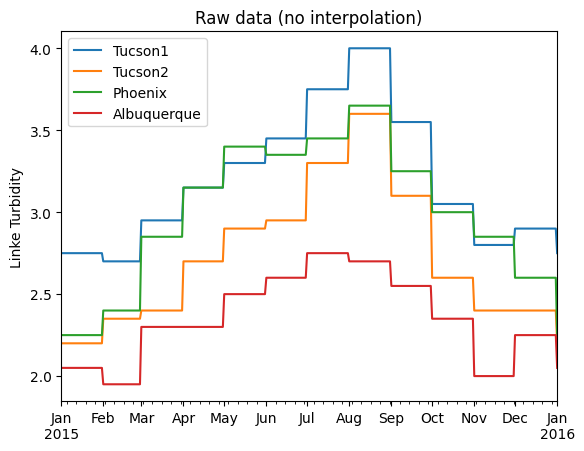

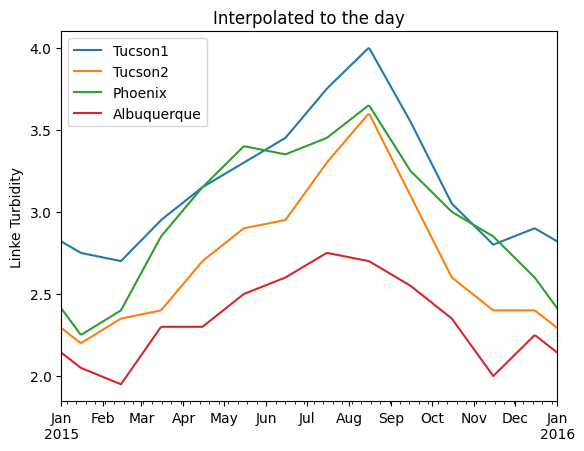

In [12]:
times = pd.date_range(start='2015-01-01', end='2016-01-01', freq='1D')

sites = [(32, -111, 'Tucson1'), (32.2, -110.9, 'Tucson2'),
         (33.5, -112.1, 'Phoenix'), (35.1, -106.6, 'Albuquerque')]


plt.figure();

for lat, lon, name in sites:
    turbidity = pvlib.clearsky.lookup_linke_turbidity(times, lat, lon, interp_turbidity=False)
    turbidity.plot(label=name)


plt.legend();

plt.title('Raw data (no interpolation)');

plt.ylabel('Linke Turbidity');

plt.figure();

for lat, lon, name in sites:
    # turbidity = pvlib.clearsky.lookup_linke_turbidity(times, lat, lon)
    # turbidity.plot(label=name)
    turbidity2 = pvlib.clearsky.lookup_linke_turbidity(times, lat, lon)
    turbidity2.plot(label=name)


plt.legend();

plt.title('Interpolated to the day');

plt.ylabel('Linke Turbidity');

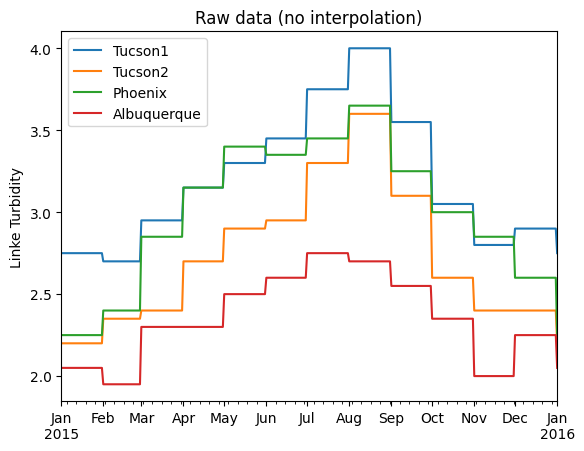

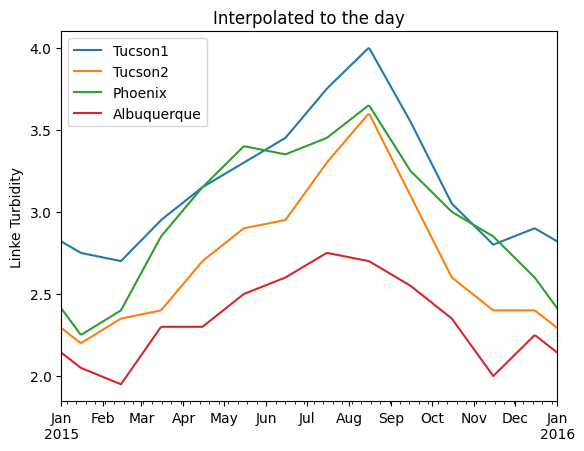

In [13]:
# times = pd.date_range(start='2015-01-01', end='2016-01-01', freq='1D')
times_kst = pd.date_range(start='2015-01-01', end='2016-01-01', freq='1D').tz_localize('utc').tz_convert('Asia/Seoul')

sites = [(32, -111, 'Tucson1'), (32.2, -110.9, 'Tucson2'),
         (33.5, -112.1, 'Phoenix'), (35.1, -106.6, 'Albuquerque')]


plt.figure();

for lat, lon, name in sites:
    # turbidity = pvlib.clearsky.lookup_linke_turbidity(times, lat, lon, interp_turbidity=False)
    # turbidity.plot(label=name)
    turbidity_kst = pvlib.clearsky.lookup_linke_turbidity(times_kst, lat, lon, interp_turbidity=False).tz_convert(None)
    turbidity_kst.plot(label=name)


plt.legend();

plt.title('Raw data (no interpolation)');

plt.ylabel('Linke Turbidity');

plt.figure();

for lat, lon, name in sites:
    # turbidity = pvlib.clearsky.lookup_linke_turbidity(times, lat, lon)
    # turbidity.plot(label=name)
    turbidity2_kst = pvlib.clearsky.lookup_linke_turbidity(times_kst, lat, lon).tz_convert(None)
    turbidity2_kst.plot(label=name)


plt.legend();

plt.title('Interpolated to the day');

plt.ylabel('Linke Turbidity');

In [14]:
assert turbidity.index.equals(turbidity_kst.index)
assert not ((turbidity < 0).any() or (turbidity_kst < 0).any())
print(len(turbidity))
df = pd.concat([turbidity, turbidity_kst], axis = 'columns', join = 'outer')[~ turbidity.fillna(-1).eq(turbidity_kst.fillna(-1))]
print(df.index.hour.unique(), df.index.minute.nunique())
df

366
Index([], dtype='int32') 0


,0,1


In [15]:
assert turbidity2.index.equals(turbidity2_kst.index)
assert not ((turbidity2 < 0).any() or (turbidity2_kst < 0).any())
print(len(turbidity2))
df = pd.concat([turbidity2, turbidity2_kst], axis = 'columns', join = 'outer')[~ turbidity2.fillna(-1).eq(turbidity2_kst.fillna(-1))]
print(df.index.hour.unique(), df.index.minute.nunique())
df

366
Index([], dtype='int32') 0


,0,1


In [16]:
turbidity.equals(turbidity_kst)

True

In [17]:
turbidity2.equals(turbidity2_kst)

True

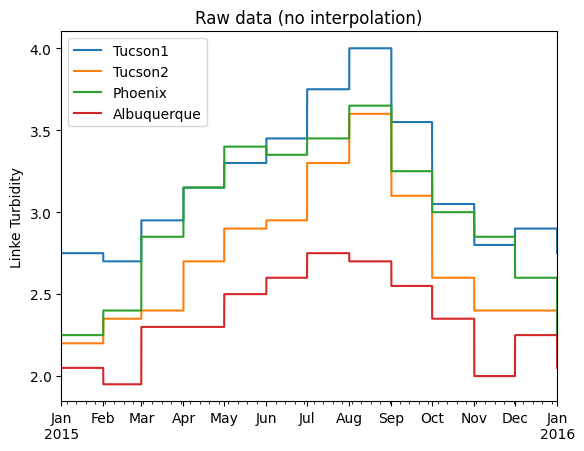

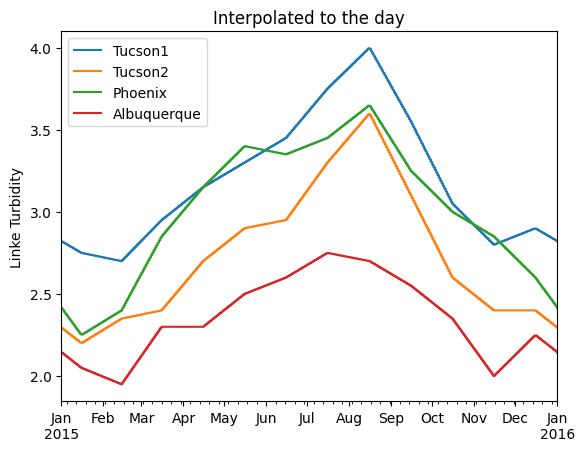

In [18]:
# times = pd.date_range(start='2015-01-01', end='2016-01-01', freq='1D')
times_h = pd.date_range(start='2015-01-01', end='2016-01-01', freq='1h')

sites = [(32, -111, 'Tucson1'), (32.2, -110.9, 'Tucson2'),
         (33.5, -112.1, 'Phoenix'), (35.1, -106.6, 'Albuquerque')]


plt.figure();

for lat, lon, name in sites:
    # turbidity = pvlib.clearsky.lookup_linke_turbidity(times, lat, lon, interp_turbidity=False)
    # turbidity.plot(label=name)
    turbidity_h = pvlib.clearsky.lookup_linke_turbidity(times_h, lat, lon, interp_turbidity=False)
    turbidity_h.plot(label=name)


plt.legend();

plt.title('Raw data (no interpolation)');

plt.ylabel('Linke Turbidity');

plt.figure();

for lat, lon, name in sites:
    # turbidity = pvlib.clearsky.lookup_linke_turbidity(times, lat, lon)
    # turbidity.plot(label=name)
    turbidity2_h = pvlib.clearsky.lookup_linke_turbidity(times_h, lat, lon)
    turbidity2_h.plot(label=name)


plt.legend();

plt.title('Interpolated to the day');

plt.ylabel('Linke Turbidity');

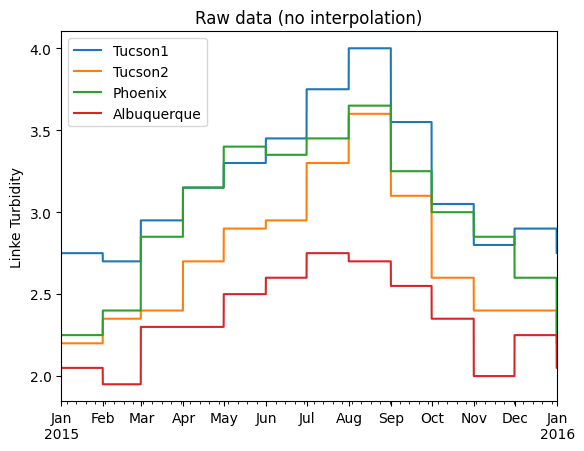

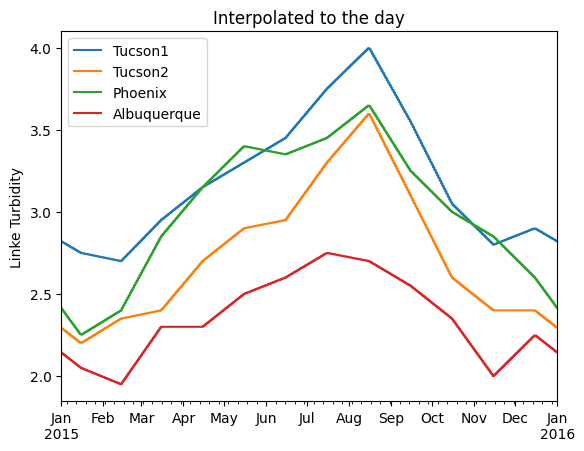

In [19]:
# times = pd.date_range(start='2015-01-01', end='2016-01-01', freq='1D')
times_h_kst = pd.date_range(start='2015-01-01', end='2016-01-01', freq='1h').tz_localize('utc').tz_convert('Asia/Seoul')

sites = [(32, -111, 'Tucson1'), (32.2, -110.9, 'Tucson2'),
         (33.5, -112.1, 'Phoenix'), (35.1, -106.6, 'Albuquerque')]


plt.figure();

for lat, lon, name in sites:
    # turbidity = pvlib.clearsky.lookup_linke_turbidity(times, lat, lon, interp_turbidity=False)
    # turbidity.plot(label=name)
    turbidity_h_kst = pvlib.clearsky.lookup_linke_turbidity(times_h_kst, lat, lon, interp_turbidity=False).tz_convert(None)
    turbidity_h_kst.plot(label=name)


plt.legend();

plt.title('Raw data (no interpolation)');

plt.ylabel('Linke Turbidity');

plt.figure();

for lat, lon, name in sites:
    # turbidity = pvlib.clearsky.lookup_linke_turbidity(times, lat, lon)
    # turbidity.plot(label=name)
    turbidity2_h_kst = pvlib.clearsky.lookup_linke_turbidity(times_h_kst, lat, lon).tz_convert(None)
    turbidity2_h_kst.plot(label=name)


plt.legend();

plt.title('Interpolated to the day');

plt.ylabel('Linke Turbidity');

In [20]:
assert turbidity_h.index.equals(turbidity_h_kst.index)
assert not ((turbidity_h < 0).any() or (turbidity_h_kst < 0).any())
print(len(turbidity_h))
df = pd.concat([turbidity_h, turbidity_h_kst], axis = 'columns', join = 'outer')[~ turbidity_h.fillna(-1).eq(turbidity_h_kst.fillna(-1))]
print(df.index.hour.unique(), df.index.minute.nunique())
df

8761
Index([15, 16, 17, 18, 19, 20, 21, 22, 23], dtype='int32') 1


,0,1
2015-01-31 15:00:00,2.05,1.95
2015-01-31 16:00:00,2.05,1.95
2015-01-31 17:00:00,2.05,1.95
2015-01-31 18:00:00,2.05,1.95
2015-01-31 19:00:00,2.05,1.95
...,...,...
2015-12-31 19:00:00,2.25,2.05
2015-12-31 20:00:00,2.25,2.05
2015-12-31 21:00:00,2.25,2.05
2015-12-31 22:00:00,2.25,2.05


In [21]:
assert turbidity2_h.index.equals(turbidity2_h_kst.index)
assert not ((turbidity2_h < 0).any() or (turbidity2_h_kst < 0).any())
print(len(turbidity2_h))
df = pd.concat([turbidity2_h, turbidity2_h_kst], axis = 'columns', join = 'outer')[~ turbidity2_h.fillna(-1).eq(turbidity2_h_kst.fillna(-1))]
print(df.index.hour.unique(), df.index.minute.nunique())
df

8761
Index([15, 16, 17, 18, 19, 20, 21, 22, 23], dtype='int32') 1


,0,1
2015-01-01 15:00:00,2.143548,2.137097
2015-01-01 16:00:00,2.143548,2.137097
2015-01-01 17:00:00,2.143548,2.137097
2015-01-01 18:00:00,2.143548,2.137097
2015-01-01 19:00:00,2.143548,2.137097
...,...,...
2015-12-31 19:00:00,2.150000,2.143548
2015-12-31 20:00:00,2.150000,2.143548
2015-12-31 21:00:00,2.150000,2.143548
2015-12-31 22:00:00,2.150000,2.143548


The :py:func:`~pvlib.atmosphere.kasten96_lt` function can be used to calculate
Linke turbidity [Kas96]_ as input to the clear sky Ineichen and Perez function.
The Kasten formulation requires precipitable water and broadband aerosol
optical depth (AOD). According to Molineaux, broadband AOD can be approximated
by a single measurement at 700-nm [Mol98]_. An alternate broadband AOD
approximation from Bird and Hulstrom combines AOD measured at two
wavelengths [Bir80]_, and is implemented in
:py:func:`~pvlib.atmosphere.bird_hulstrom80_aod_bb`.

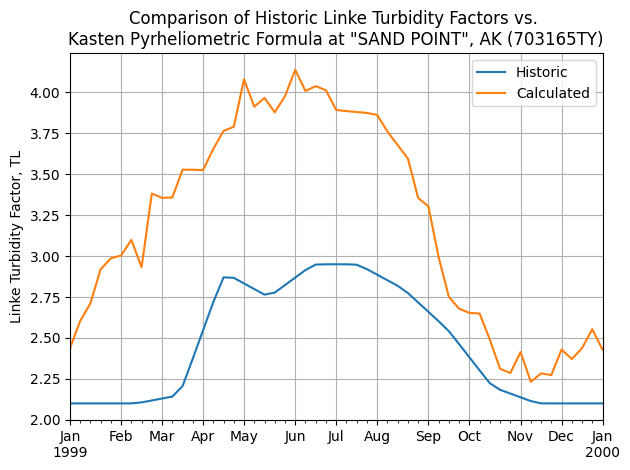

In [22]:
pvlib_data = os.path.join(os.path.dirname(pvlib.__file__), 'data')

mbars = 100  # conversion factor from mbars to Pa

tmy_file = os.path.join(pvlib_data, '703165TY.csv')  # TMY file

tmy_data, tmy_header = read_tmy3(tmy_file, coerce_year=1999, map_variables=True)

tl_historic = clearsky.lookup_linke_turbidity(time=tmy_data.index,
    latitude=tmy_header['latitude'], longitude=tmy_header['longitude'])


solpos = solarposition.get_solarposition(time=tmy_data.index,
    latitude=tmy_header['latitude'], longitude=tmy_header['longitude'],
    altitude=tmy_header['altitude'], pressure=tmy_data['pressure']*mbars,
    temperature=tmy_data['temp_air'])


am_rel = atmosphere.get_relative_airmass(solpos.apparent_zenith)

am_abs = atmosphere.get_absolute_airmass(am_rel, tmy_data['pressure']*mbars)

airmass = pd.concat([am_rel, am_abs], axis=1).rename(
    columns={0: 'airmass_relative', 1: 'airmass_absolute'})


tl_calculated = atmosphere.kasten96_lt(
    airmass.airmass_absolute, tmy_data['precipitable_water'],
    tmy_data['AOD (unitless)'])


tl = pd.concat([tl_historic, tl_calculated], axis=1).rename(
    columns={0:'Historic', 1:'Calculated'})


tl.index = tmy_data.index.tz_convert(None)  # remove timezone

tl.resample('W').mean().plot();

plt.grid()

plt.title('Comparison of Historic Linke Turbidity Factors vs. \n'
    'Kasten Pyrheliometric Formula at {name:s}, {state:s} ({usaf:d}TY)'.format(
    name=tmy_header['Name'], state=tmy_header['State'], usaf=tmy_header['USAF']));


plt.ylabel('Linke Turbidity Factor, TL');

plt.tight_layout()

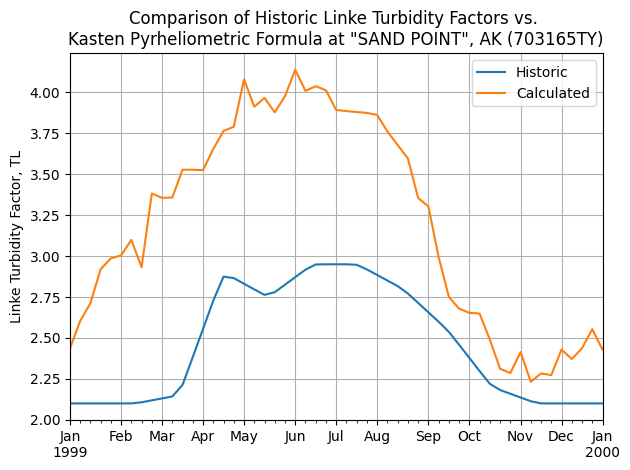

In [23]:
pvlib_data = os.path.join(os.path.dirname(pvlib.__file__), 'data')

mbars = 100  # conversion factor from mbars to Pa

tmy_file = os.path.join(pvlib_data, '703165TY.csv')  # TMY file

tmy_data, tmy_header = read_tmy3(tmy_file, coerce_year=1999, map_variables=True)

# tl_historic = clearsky.lookup_linke_turbidity(time=tmy_data.index,
#     latitude=tmy_header['latitude'], longitude=tmy_header['longitude'])
tl_historic_utc = clearsky.lookup_linke_turbidity(time=tmy_data.index.tz_convert('utc'),
    latitude=tmy_header['latitude'], longitude=tmy_header['longitude']).tz_convert(tmy_data.index.tz)


# solpos = solarposition.get_solarposition(time=tmy_data.index,
#     latitude=tmy_header['latitude'], longitude=tmy_header['longitude'],
#     altitude=tmy_header['altitude'], pressure=tmy_data['pressure']*mbars,
#     temperature=tmy_data['temp_air'])
solpos_utc = solarposition.get_solarposition(time=tmy_data.index.tz_convert('utc'),
    latitude=tmy_header['latitude'], longitude=tmy_header['longitude'],
    altitude=tmy_header['altitude'], pressure=tmy_data['pressure'].tz_convert('utc')*mbars,
    temperature=tmy_data['temp_air'].tz_convert('utc')).tz_convert(tmy_data.index.tz)


# am_rel = atmosphere.get_relative_airmass(solpos.apparent_zenith)
am_rel_utc = atmosphere.get_relative_airmass(solpos_utc.tz_convert('utc').apparent_zenith).tz_convert(tmy_data.index.tz)
am_rel_utc2 = atmosphere.get_relative_airmass(solpos_utc.apparent_zenith)

# am_abs = atmosphere.get_absolute_airmass(am_rel, tmy_data['pressure']*mbars)
am_abs_utc = atmosphere.get_absolute_airmass(am_rel_utc.tz_convert('utc'), tmy_data['pressure'].tz_convert('utc')*mbars).tz_convert(tmy_data.index.tz)
am_abs_utc2 = atmosphere.get_absolute_airmass(am_rel_utc, tmy_data['pressure']*mbars)

# airmass = pd.concat([am_rel, am_abs], axis=1).rename(
#     columns={0: 'airmass_relative', 1: 'airmass_absolute'})
airmass_utc = pd.concat([am_rel_utc.tz_convert('utc'), am_abs_utc.tz_convert('utc')], axis=1).rename(
    columns={0: 'airmass_relative', 1: 'airmass_absolute'}).tz_convert(tmy_data.index.tz)
airmass_utc2 = pd.concat([am_rel_utc, am_abs_utc], axis=1).rename(
    columns={0: 'airmass_relative', 1: 'airmass_absolute'})


# tl_calculated = atmosphere.kasten96_lt(
#     airmass.airmass_absolute, tmy_data['precipitable_water'],
#     tmy_data['AOD (unitless)'])
tl_calculated_utc = atmosphere.kasten96_lt(
    airmass_utc.tz_convert('utc').airmass_absolute, tmy_data['precipitable_water'].tz_convert('utc'),
    tmy_data['AOD (unitless)'].tz_convert('utc')).tz_convert(tmy_data.index.tz)
tl_calculated_utc2 = atmosphere.kasten96_lt(
    airmass_utc.airmass_absolute, tmy_data['precipitable_water'],
    tmy_data['AOD (unitless)'])


# tl = pd.concat([tl_historic, tl_calculated], axis=1).rename(
tl_utc = pd.concat([tl_historic_utc, tl_calculated_utc], axis=1).rename(
    columns={0:'Historic', 1:'Calculated'})


# tl.index = tmy_data.index.tz_convert(None)  # remove timezone
tl_utc.index = tmy_data.index.tz_convert(None)  # remove timezone

# tl.resample('W').mean().plot();
tl_utc.resample('W').mean().plot();

plt.grid()

plt.title('Comparison of Historic Linke Turbidity Factors vs. \n'
    'Kasten Pyrheliometric Formula at {name:s}, {state:s} ({usaf:d}TY)'.format(
    name=tmy_header['Name'], state=tmy_header['State'], usaf=tmy_header['USAF']));


plt.ylabel('Linke Turbidity Factor, TL');

plt.tight_layout()

In [24]:
assert tl_historic.index.equals(tl_historic_utc.index)
assert not ((tl_historic < 0).any() or (tl_historic_utc < 0).any())
print(len(tl_historic))
df = pd.concat([tl_historic, tl_historic_utc], axis = 'columns', join = 'outer')[~ tl_historic.fillna(-1).eq(tl_historic_utc.fillna(-1))]
print(df.index.hour.unique(), df.index.minute.nunique())
df

8760
Index([15, 16, 17, 18, 19, 20, 21, 22, 23], dtype='int32') 1


,0,1
1999-02-14 15:00:00-09:00,2.100000,2.101695
1999-02-14 16:00:00-09:00,2.100000,2.101695
1999-02-14 17:00:00-09:00,2.100000,2.101695
1999-02-14 18:00:00-09:00,2.100000,2.101695
1999-02-14 19:00:00-09:00,2.100000,2.101695
...,...,...
1999-11-14 19:00:00-09:00,2.103279,2.100000
1999-11-14 20:00:00-09:00,2.103279,2.100000
1999-11-14 21:00:00-09:00,2.103279,2.100000
1999-11-14 22:00:00-09:00,2.103279,2.100000


In [25]:
solpos.equals(solpos_utc)

True

In [26]:
am_rel.equals(am_rel_utc)

True

In [27]:
am_rel_utc.equals(am_rel_utc2)

True

In [28]:
am_abs.equals(am_abs_utc)

True

In [29]:
am_abs_utc.equals(am_abs_utc2)

True

In [30]:
airmass.equals(airmass_utc)

True

In [31]:
airmass_utc.equals(airmass_utc2)

True

In [32]:
tl_calculated.equals(tl_calculated_utc)

True

In [33]:
tl_calculated_utc.equals(tl_calculated_utc2)

True

In [34]:
assert tl.index.equals(tl_utc.index)
assert not ((tl < 0).any().any() or (tl_utc < 0).any().any())
print(len(tl))
df = tl.join(tl_utc, how = 'outer', rsuffix = '_utc')[~ tl.fillna(-1).eq(tl_utc.fillna(-1)).all(axis = 'columns')]
print(df.index.hour.unique(), df.index.minute.nunique())
df

8760
Index([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int32') 1


,Historic,Calculated,Historic_utc,Calculated_utc
1999-02-15 00:00:00,2.100000,2.856395,2.101695,2.856395
1999-02-15 01:00:00,2.100000,2.807920,2.101695,2.807920
1999-02-15 02:00:00,2.100000,2.842227,2.101695,2.842227
1999-02-15 03:00:00,2.100000,3.218950,2.101695,3.218950
1999-02-15 04:00:00,2.100000,NaN,2.101695,NaN
...,...,...,...,...
1999-11-15 04:00:00,2.103279,NaN,2.100000,NaN
1999-11-15 05:00:00,2.103279,NaN,2.100000,NaN
1999-11-15 06:00:00,2.103279,NaN,2.100000,NaN
1999-11-15 07:00:00,2.103279,NaN,2.100000,NaN


In [35]:
tl['Calculated'].equals(tl_utc['Calculated'])

True

Examples
^^^^^^^^

A clear sky time series using only basic pvlib functions.

<Figure size 640x480 with 0 Axes>

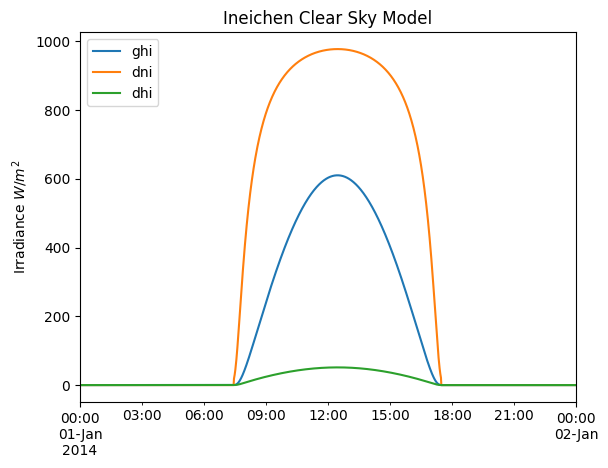

In [36]:
latitude, longitude, tz, altitude, name = 32.2, -111, 'US/Arizona', 700, 'Tucson'

times = pd.date_range(start='2014-01-01', end='2014-01-02', freq='1Min', tz=tz)

solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)

apparent_zenith = solpos['apparent_zenith']

airmass = pvlib.atmosphere.get_relative_airmass(apparent_zenith)

pressure = pvlib.atmosphere.alt2pres(altitude)

# airmass = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
airmass2 = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)

linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(times, latitude, longitude)

dni_extra = pvlib.irradiance.get_extra_radiation(times)


# ineichen = clearsky.ineichen(apparent_zenith, airmass, linke_turbidity, altitude, dni_extra)
ineichen = clearsky.ineichen(apparent_zenith, airmass2, linke_turbidity, altitude, dni_extra)

plt.figure();

ax = ineichen.plot()

ax.set_ylabel('Irradiance $W/m^2$');

ax.set_title('Ineichen Clear Sky Model');

ax.legend(loc=2);

<Figure size 640x480 with 0 Axes>

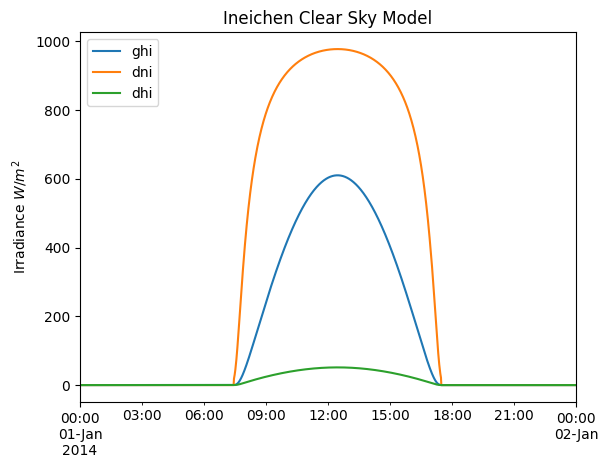

In [37]:
latitude, longitude, tz, altitude, name = 32.2, -111, 'US/Arizona', 700, 'Tucson'

# times = pd.date_range(start='2014-01-01', end='2014-01-02', freq='1Min', tz=tz)
times_utc = pd.date_range(start='2014-01-01', end='2014-01-02', freq='1Min', tz=tz).tz_convert('utc')

# solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)
solpos_utc = pvlib.solarposition.get_solarposition(times_utc, latitude, longitude).tz_convert(tz)

# apparent_zenith = solpos['apparent_zenith']
apparent_zenith_utc = solpos_utc['apparent_zenith']

# airmass = pvlib.atmosphere.get_relative_airmass(apparent_zenith)
airmass_utc = pvlib.atmosphere.get_relative_airmass(apparent_zenith_utc.tz_convert('utc')).tz_convert(tz)
airmass_utc2 = pvlib.atmosphere.get_relative_airmass(apparent_zenith_utc)

pressure = pvlib.atmosphere.alt2pres(altitude)

# airmass = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
airmass2_utc = pvlib.atmosphere.get_absolute_airmass(airmass_utc.tz_convert('utc'), pressure).tz_convert(tz)
airmass2_utc2 = pvlib.atmosphere.get_absolute_airmass(airmass_utc, pressure)

# linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(times, latitude, longitude)
linke_turbidity_utc = pvlib.clearsky.lookup_linke_turbidity(times_utc, latitude, longitude).tz_convert(tz)

# dni_extra = pvlib.irradiance.get_extra_radiation(times)
dni_extra_utc = pvlib.irradiance.get_extra_radiation(times_utc).tz_convert(tz)


# ineichen = clearsky.ineichen(apparent_zenith, airmass, linke_turbidity, altitude, dni_extra)
ineichen_utc = clearsky.ineichen(apparent_zenith_utc.tz_convert('utc'), airmass2_utc.tz_convert('utc'), linke_turbidity_utc.tz_convert('utc'), altitude, dni_extra_utc.tz_convert('utc')).tz_convert(tz)
ineichen_utc2 = clearsky.ineichen(apparent_zenith_utc, airmass2_utc, linke_turbidity_utc, altitude, dni_extra_utc)

plt.figure();

# ax = ineichen.plot()
ax = ineichen_utc.plot()

ax.set_ylabel('Irradiance $W/m^2$');

ax.set_title('Ineichen Clear Sky Model');

ax.legend(loc=2);

In [38]:
solpos.equals(solpos_utc)

True

In [39]:
airmass.equals(airmass_utc)

True

In [40]:
airmass_utc.equals(airmass_utc2)

True

In [41]:
airmass2.equals(airmass2_utc)

True

In [42]:
airmass2_utc.equals(airmass2_utc2)

True

In [43]:
assert linke_turbidity.index.equals(linke_turbidity_utc.index)
assert not ((linke_turbidity < 0).any() or (linke_turbidity_utc < 0).any())
print(len(linke_turbidity))
df = pd.concat([linke_turbidity, linke_turbidity_utc], axis = 'columns', join = 'outer')[~ linke_turbidity.fillna(-1).eq(linke_turbidity_utc.fillna(-1))]
print(df.index.hour.unique(), df.index.minute.nunique())
df

1441
Index([17, 18, 19, 20, 21, 22, 23], dtype='int32') 60


,0,1
2014-01-01 17:00:00-07:00,2.366935,2.358871
2014-01-01 17:01:00-07:00,2.366935,2.358871
2014-01-01 17:02:00-07:00,2.366935,2.358871
2014-01-01 17:03:00-07:00,2.366935,2.358871
2014-01-01 17:04:00-07:00,2.366935,2.358871
...,...,...
2014-01-01 23:55:00-07:00,2.366935,2.358871
2014-01-01 23:56:00-07:00,2.366935,2.358871
2014-01-01 23:57:00-07:00,2.366935,2.358871
2014-01-01 23:58:00-07:00,2.366935,2.358871


In [44]:
assert dni_extra.index.equals(dni_extra_utc.index)
assert not ((dni_extra < 0).any() or (dni_extra_utc < 0).any())
print(len(dni_extra))
df = pd.concat([dni_extra, dni_extra_utc], axis = 'columns', join = 'outer')[~ dni_extra.fillna(-1).eq(dni_extra_utc.fillna(-1))]
print(df.index.hour.unique(), df.index.minute.nunique())
df

1441
Index([17, 18, 19, 20, 21, 22, 23], dtype='int32') 60


,0,1
2014-01-01 17:00:00-07:00,1413.981805,1414.008017
2014-01-01 17:01:00-07:00,1413.981805,1414.008017
2014-01-01 17:02:00-07:00,1413.981805,1414.008017
2014-01-01 17:03:00-07:00,1413.981805,1414.008017
2014-01-01 17:04:00-07:00,1413.981805,1414.008017
...,...,...
2014-01-01 23:55:00-07:00,1413.981805,1414.008017
2014-01-01 23:56:00-07:00,1413.981805,1414.008017
2014-01-01 23:57:00-07:00,1413.981805,1414.008017
2014-01-01 23:58:00-07:00,1413.981805,1414.008017


In [45]:
assert ineichen.index.equals(ineichen_utc.index)
assert not ((ineichen < 0).any().any() or (ineichen_utc < 0).any().any())
print(len(ineichen))
df = ineichen.join(ineichen_utc, how = 'outer', rsuffix = '_utc')[~ ineichen.fillna(-1).eq(ineichen_utc.fillna(-1)).all(axis = 'columns')]
print(df.index.hour.unique(), df.index.minute.nunique())
df

1441
Index([17], dtype='int32') 29


,ghi,dni,dhi,ghi_utc,dni_utc,dhi_utc
2014-01-01 17:00:00-07:00,37.805180,367.804081,6.028042,37.916010,370.368444,5.917318
2014-01-01 17:01:00-07:00,35.308029,355.072696,5.721366,35.414627,357.622614,5.615491
2014-01-01 17:02:00-07:00,32.869715,342.086719,5.416059,32.971994,344.619123,5.315104
2014-01-01 17:03:00-07:00,30.493660,328.853336,5.112467,30.591535,331.364894,5.016498
2014-01-01 17:04:00-07:00,28.183416,315.382219,4.810982,28.276805,317.869323,4.720055
2014-01-01 17:05:00-07:00,25.942650,301.685895,4.512037,26.031476,304.144647,4.426203
2014-01-01 17:06:00-07:00,23.775132,287.780135,4.216121,23.859325,290.206338,4.135416
2014-01-01 17:07:00-07:00,21.684719,273.684423,3.923774,21.764215,276.073574,3.848225
2014-01-01 17:08:00-07:00,19.675316,259.422361,3.635596,19.750064,261.769649,3.565215
2014-01-01 17:09:00-07:00,17.750853,245.022183,3.352248,17.820809,247.322491,3.287029


In [46]:
assert ineichen_utc.index.equals(ineichen_utc2.index)
assert not ((ineichen_utc < 0).any().any() or (ineichen_utc2 < 0).any().any())
print(len(ineichen_utc))
df = ineichen_utc.join(ineichen_utc2, how = 'outer', rsuffix = '_utc')[~ ineichen_utc.fillna(-1).eq(ineichen_utc2.fillna(-1)).all(axis = 'columns')]
print(df.index.hour.unique(), df.index.minute.nunique())
df

1441
Index([], dtype='int32') 0


,ghi,dni,dhi,ghi_utc,dni_utc,dhi_utc


In [47]:
ineichen_utc.equals(ineichen_utc2)

True

The input data types determine the returned output type. Array input
results in an OrderedDict of array output, and Series input results in a
DataFrame output. The keys are 'ghi', 'dni', and 'dhi'.

Grid with a clear sky irradiance for a few turbidity values.

climatological linke_turbidity = 3.329496820286459


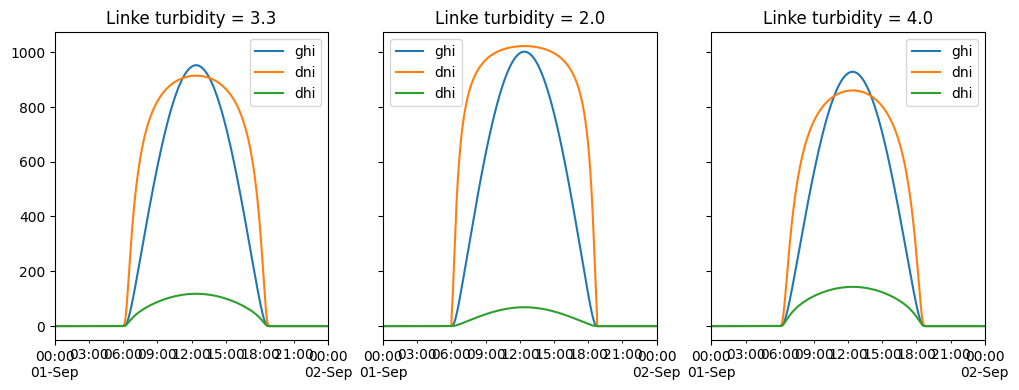

In [48]:
times = pd.date_range(start='2014-09-01', end='2014-09-02', freq='1Min', tz=tz)

solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)

apparent_zenith = solpos['apparent_zenith']

airmass = pvlib.atmosphere.get_relative_airmass(apparent_zenith)

pressure = pvlib.atmosphere.alt2pres(altitude)

# airmass = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
airmass2 = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)

linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(times, latitude, longitude)

print('climatological linke_turbidity = {}'.format(linke_turbidity.mean()))


dni_extra = pvlib.irradiance.get_extra_radiation(times)

linke_turbidities = [linke_turbidity.mean(), 2, 4]

fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=True, squeeze=True, figsize=(12, 4))

axes = axes.flatten()

# for linke_turbidity, ax in zip(linke_turbidities, axes):
#     ineichen = clearsky.ineichen(apparent_zenith, airmass, linke_turbidity, altitude, dni_extra)
#     ineichen.plot(ax=ax, title='Linke turbidity = {:0.1f}'.format(linke_turbidity));
for linke_turbidity2, ax in zip(linke_turbidities, axes):
    ineichen = clearsky.ineichen(apparent_zenith, airmass2, linke_turbidity2, altitude, dni_extra)
    ineichen.plot(ax=ax, title='Linke turbidity = {:0.1f}'.format(linke_turbidity2));


ax.legend(loc=1);

climatological linke_turbidity = 3.3247187176482633


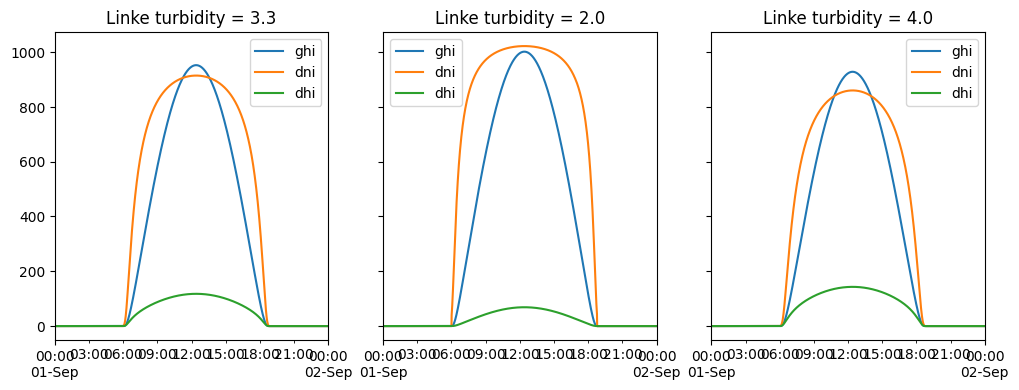

In [49]:
# times = pd.date_range(start='2014-09-01', end='2014-09-02', freq='1Min', tz=tz)
times_utc = pd.date_range(start='2014-09-01', end='2014-09-02', freq='1Min', tz=tz).tz_convert('utc')

# solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)
solpos_utc = pvlib.solarposition.get_solarposition(times_utc, latitude, longitude).tz_convert(tz)

# apparent_zenith = solpos['apparent_zenith']
apparent_zenith_utc = solpos_utc['apparent_zenith']

# airmass = pvlib.atmosphere.get_relative_airmass(apparent_zenith)
airmass_utc = pvlib.atmosphere.get_relative_airmass(apparent_zenith_utc.tz_convert('utc')).tz_convert(tz)
airmass_utc2 = pvlib.atmosphere.get_relative_airmass(apparent_zenith_utc)

pressure = pvlib.atmosphere.alt2pres(altitude)

# airmass = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
airmass2_utc = pvlib.atmosphere.get_absolute_airmass(airmass_utc.tz_convert('utc'), pressure).tz_convert(tz)
airmass2_utc2 = pvlib.atmosphere.get_absolute_airmass(airmass_utc, pressure)

# linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(times, latitude, longitude)
linke_turbidity_utc = pvlib.clearsky.lookup_linke_turbidity(times_utc, latitude, longitude).tz_convert(tz)

# print('climatological linke_turbidity = {}'.format(linke_turbidity.mean()))
print('climatological linke_turbidity = {}'.format(linke_turbidity_utc.mean()))


# dni_extra = pvlib.irradiance.get_extra_radiation(times)
dni_extra_utc = pvlib.irradiance.get_extra_radiation(times_utc).tz_convert(tz)

# linke_turbidities = [linke_turbidity.mean(), 2, 4]
linke_turbidities_utc = [linke_turbidity_utc.mean(), 2, 4]

fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=True, squeeze=True, figsize=(12, 4))

axes = axes.flatten()

# for linke_turbidity, ax in zip(linke_turbidities_utc, axes):
#     ineichen = clearsky.ineichen(apparent_zenith, airmass, linke_turbidity, altitude, dni_extra)
#     ineichen.plot(ax=ax, title='Linke turbidity = {:0.1f}'.format(linke_turbidity));
for linke_turbidity2_utc, ax in zip(linke_turbidities_utc, axes):
    ineichen_utc = clearsky.ineichen(apparent_zenith_utc.tz_convert('utc'), airmass2_utc.tz_convert('utc'), linke_turbidity2_utc, altitude, dni_extra_utc.tz_convert('utc')).tz_convert(tz)
    ineichen_utc2 = clearsky.ineichen(apparent_zenith_utc, airmass2_utc, linke_turbidity2_utc, altitude, dni_extra_utc)
    ineichen_utc.plot(ax=ax, title='Linke turbidity = {:0.1f}'.format(linke_turbidity2_utc));


ax.legend(loc=1);

In [50]:
solpos.equals(solpos_utc)

True

In [51]:
airmass.equals(airmass_utc)

True

In [52]:
airmass_utc.equals(airmass_utc2)

True

In [53]:
airmass2.equals(airmass2_utc)

True

In [54]:
airmass2_utc.equals(airmass2_utc2)

True

In [55]:
assert linke_turbidity.index.equals(linke_turbidity_utc.index)
assert not ((linke_turbidity < 0).any() or (linke_turbidity_utc < 0).any())
print(len(linke_turbidity))
df = pd.concat([linke_turbidity, linke_turbidity_utc], axis = 'columns', join = 'outer')[~ linke_turbidity.fillna(-1).eq(linke_turbidity_utc.fillna(-1))]
print(df.index.hour.unique(), df.index.minute.nunique())
df

1441
Index([17, 18, 19, 20, 21, 22, 23], dtype='int32') 60


,0,1
2014-09-01 17:00:00-07:00,3.329508,3.313115
2014-09-01 17:01:00-07:00,3.329508,3.313115
2014-09-01 17:02:00-07:00,3.329508,3.313115
2014-09-01 17:03:00-07:00,3.329508,3.313115
2014-09-01 17:04:00-07:00,3.329508,3.313115
...,...,...
2014-09-01 23:55:00-07:00,3.329508,3.313115
2014-09-01 23:56:00-07:00,3.329508,3.313115
2014-09-01 23:57:00-07:00,3.329508,3.313115
2014-09-01 23:58:00-07:00,3.329508,3.313115


In [56]:
assert dni_extra.index.equals(dni_extra_utc.index)
assert not ((dni_extra < 0).any() or (dni_extra_utc < 0).any())
print(len(dni_extra))
df = pd.concat([dni_extra, dni_extra_utc], axis = 'columns', join = 'outer')[~ dni_extra.fillna(-1).eq(dni_extra_utc.fillna(-1))]
print(df.index.hour.unique(), df.index.minute.nunique())
df

1441
Index([17, 18, 19, 20, 21, 22, 23], dtype='int32') 60


,0,1
2014-09-01 17:00:00-07:00,1340.74477,1341.396857
2014-09-01 17:01:00-07:00,1340.74477,1341.396857
2014-09-01 17:02:00-07:00,1340.74477,1341.396857
2014-09-01 17:03:00-07:00,1340.74477,1341.396857
2014-09-01 17:04:00-07:00,1340.74477,1341.396857
...,...,...
2014-09-01 23:55:00-07:00,1340.74477,1341.396857
2014-09-01 23:56:00-07:00,1340.74477,1341.396857
2014-09-01 23:57:00-07:00,1340.74477,1341.396857
2014-09-01 23:58:00-07:00,1340.74477,1341.396857


In [57]:
assert ineichen.index.equals(ineichen_utc.index)
assert not ((ineichen < 0).any().any() or (ineichen_utc < 0).any().any())
print(len(ineichen))
df = ineichen.join(ineichen_utc, how = 'outer', rsuffix = '_utc')[~ ineichen.fillna(-1).eq(ineichen_utc.fillna(-1)).all(axis = 'columns')]
print(df.index.hour.unique(), df.index.minute.nunique())
df

1441
Index([17, 18], dtype='int32') 60


,ghi,dni,dhi,ghi_utc,dni_utc,dhi_utc
2014-09-01 17:00:00-07:00,297.046891,584.122145,78.116829,297.191364,584.406240,78.154822
2014-09-01 17:01:00-07:00,293.212978,580.645479,77.567100,293.355585,580.927883,77.604826
2014-09-01 17:02:00-07:00,289.377750,577.121291,77.013001,289.518492,577.401981,77.050457
2014-09-01 17:03:00-07:00,285.541427,573.548769,76.454463,285.680304,573.827721,76.491647
2014-09-01 17:04:00-07:00,281.704234,569.927082,75.891415,281.841245,570.204273,75.928326
...,...,...,...,...,...,...
2014-09-01 18:42:00-07:00,0.223747,1.211288,0.205442,0.223856,1.211877,0.205542
2014-09-01 18:43:00-07:00,0.132268,0.773105,0.123045,0.132332,0.773481,0.123104
2014-09-01 18:44:00-07:00,0.071113,0.474226,0.066946,0.071148,0.474456,0.066978
2014-09-01 18:45:00-07:00,0.032671,0.278818,0.031086,0.032687,0.278954,0.031102


In [58]:
ineichen_utc.equals(ineichen_utc2)

True

Validation
^^^^^^^^^^

See [Ine02]_, [Ren12]_.

Simplified Solis
----------------

The Simplified Solis model parameterizes irradiance in terms of
precipitable water and aerosol optical depth [Ine08ss]_. pvlib-python
implements this model in the :py:func:`pvlib.clearsky.simplified_solis`
function.

Aerosol and precipitable water data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

There are a number of sources for aerosol and precipitable water data
of varying accuracy, global coverage, and temporal resolution.
Ground based aerosol data can be obtained from
`Aeronet <http://aeronet.gsfc.nasa.gov>`_. Precipitable water can be
derived from surface relative humidity using functions such as
:py:func:`pvlib.atmosphere.gueymard94_pw`.
Numerous gridded products from satellites, weather models, and climate models
contain one or both of aerosols and precipitable water. Consider data
from the `ECMWF ERA5 <https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5>`_,
`NASA MERRA-2 <https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/>`_,
and `SoDa <http://www.soda-pro.com/web-services/radiation/cams-mcclear>`_.

Aerosol optical depth (AOD) is a function of wavelength, and the Simplified
Solis model requires AOD at 700 nm.
:py:func:`~pvlib.atmosphere.angstrom_aod_at_lambda` is useful for converting
AOD between different wavelengths using the Angstrom turbidity model. The
Angstrom exponent, :math:`\alpha`, can be calculated from AOD at two
wavelengths with :py:func:`~pvlib.atmosphere.angstrom_alpha`.
[Ine08con]_, [Ine16]_, [Ang61]_.

In [59]:
aod1240nm = 1.2  # fictitious AOD measured at 1240-nm

aod550nm = 3.1  # fictitious AOD measured at 550-nm

alpha_exponent = atmosphere.angstrom_alpha(aod1240nm, 1240, aod550nm, 550)

aod700nm = atmosphere.angstrom_aod_at_lambda(aod1240nm, 1240, alpha_exponent, 700)

aod380nm = atmosphere.angstrom_aod_at_lambda(aod550nm, 550, alpha_exponent, 380)

aod500nm = atmosphere.angstrom_aod_at_lambda(aod550nm, 550, alpha_exponent, 500)

aod_bb = atmosphere.bird_hulstrom80_aod_bb(aod380nm, aod500nm)

print('compare AOD at 700-nm = {:g}, to estimated broadband AOD = {:g}, '
    'with alpha = {:g}'.format(aod700nm, aod_bb, alpha_exponent))

compare AOD at 700-nm = 2.33931, to estimated broadband AOD = 2.52936, with alpha = 1.16745


Examples
^^^^^^^^

A clear sky time series using only basic pvlib functions.

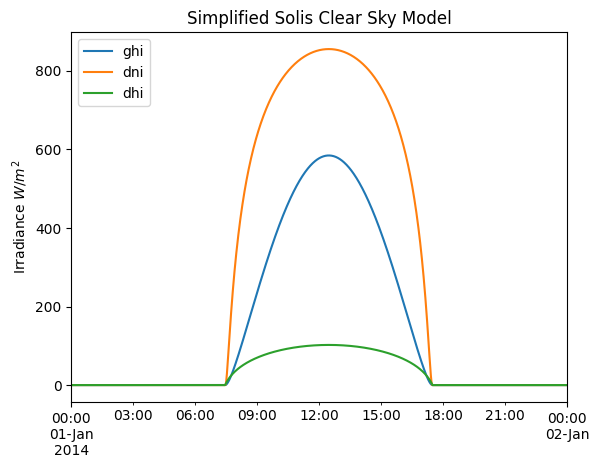

In [60]:
latitude, longitude, tz, altitude, name = 32.2, -111, 'US/Arizona', 700, 'Tucson'

times = pd.date_range(start='2014-01-01', end='2014-01-02', freq='1Min', tz=tz)

solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)

apparent_elevation = solpos['apparent_elevation']

aod700 = 0.1

precipitable_water = 1

pressure = pvlib.atmosphere.alt2pres(altitude)

dni_extra = pvlib.irradiance.get_extra_radiation(times)


solis = clearsky.simplified_solis(apparent_elevation, aod700, precipitable_water,
                                  pressure, dni_extra)


ax = solis.plot();

ax.set_ylabel('Irradiance $W/m^2$');

ax.set_title('Simplified Solis Clear Sky Model');

ax.legend(loc=2);

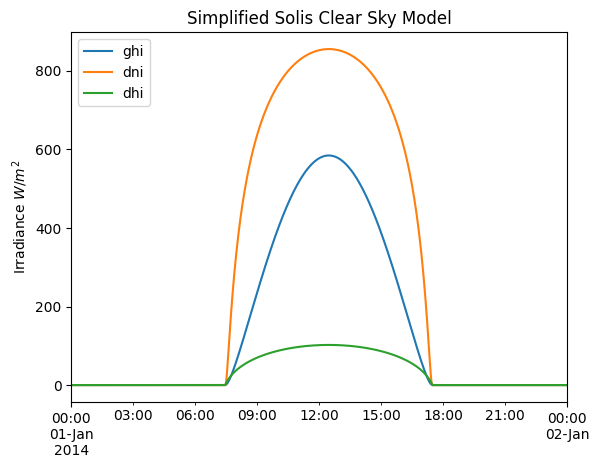

In [61]:
latitude, longitude, tz, altitude, name = 32.2, -111, 'US/Arizona', 700, 'Tucson'

# times = pd.date_range(start='2014-01-01', end='2014-01-02', freq='1Min', tz=tz)
times_utc = pd.date_range(start='2014-01-01', end='2014-01-02', freq='1Min', tz=tz).tz_convert('utc')

# solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)
solpos_utc = pvlib.solarposition.get_solarposition(times_utc, latitude, longitude).tz_convert(tz)

# apparent_elevation = solpos['apparent_elevation']
apparent_elevation_utc = solpos_utc['apparent_elevation']

aod700 = 0.1

precipitable_water = 1

pressure = pvlib.atmosphere.alt2pres(altitude)

# dni_extra = pvlib.irradiance.get_extra_radiation(times)
dni_extra_utc = pvlib.irradiance.get_extra_radiation(times_utc).tz_convert(tz)


# solis = clearsky.simplified_solis(apparent_elevation, aod700, precipitable_water,
#                                   pressure, dni_extra)
solis_utc = clearsky.simplified_solis(apparent_elevation_utc.tz_convert('utc'), aod700, precipitable_water,
                                  pressure, dni_extra_utc.tz_convert('utc')).tz_convert(tz)
solis_utc2 = clearsky.simplified_solis(apparent_elevation_utc, aod700, precipitable_water,
                                  pressure, dni_extra_utc)


# ax = solis.plot();
ax = solis_utc.plot();

ax.set_ylabel('Irradiance $W/m^2$');

ax.set_title('Simplified Solis Clear Sky Model');

ax.legend(loc=2);

In [62]:
solpos.equals(solpos_utc)

True

In [63]:
assert dni_extra.index.equals(dni_extra_utc.index)
assert not ((dni_extra < 0).any() or (dni_extra_utc < 0).any())
print(len(dni_extra))
df = pd.concat([dni_extra, dni_extra_utc], axis = 'columns', join = 'outer')[~ dni_extra.fillna(-1).eq(dni_extra_utc.fillna(-1))]
print(df.index.hour.unique(), df.index.minute.nunique())
df

1441
Index([17, 18, 19, 20, 21, 22, 23], dtype='int32') 60


,0,1
2014-01-01 17:00:00-07:00,1413.981805,1414.008017
2014-01-01 17:01:00-07:00,1413.981805,1414.008017
2014-01-01 17:02:00-07:00,1413.981805,1414.008017
2014-01-01 17:03:00-07:00,1413.981805,1414.008017
2014-01-01 17:04:00-07:00,1413.981805,1414.008017
...,...,...
2014-01-01 23:55:00-07:00,1413.981805,1414.008017
2014-01-01 23:56:00-07:00,1413.981805,1414.008017
2014-01-01 23:57:00-07:00,1413.981805,1414.008017
2014-01-01 23:58:00-07:00,1413.981805,1414.008017


In [64]:
assert solis.index.equals(solis_utc.index)
assert not ((solis < 0).any().any() or (solis_utc < 0).any().any())
print(len(solis))
df = solis.join(solis_utc, how = 'outer', rsuffix = '_utc')[~ solis.fillna(-1).eq(solis_utc.fillna(-1)).all(axis = 'columns')]
print(df.index.hour.unique(), df.index.minute.nunique())
df

1441
Index([17], dtype='int32') 29


,ghi,dni,dhi,ghi_utc,dni_utc,dhi_utc
2014-01-01 17:00:00-07:00,50.701230,303.727014,34.786544,50.702170,303.732645,34.787189
2014-01-01 17:01:00-07:00,48.154484,294.482425,33.951883,48.155376,294.487884,33.952512
2014-01-01 17:02:00-07:00,45.635563,285.015467,33.101446,45.636409,285.020750,33.102059
2014-01-01 17:03:00-07:00,43.146092,275.319414,32.234586,43.146892,275.324517,32.235183
2014-01-01 17:04:00-07:00,40.687806,265.387626,31.350609,40.688560,265.392545,31.351190
2014-01-01 17:05:00-07:00,38.262569,255.213652,30.448776,38.263278,255.218383,30.449341
2014-01-01 17:06:00-07:00,35.872384,244.791361,29.528292,35.873049,244.795899,29.528839
2014-01-01 17:07:00-07:00,33.519412,234.115145,28.588305,33.520034,234.119485,28.588835
2014-01-01 17:08:00-07:00,31.205984,223.180106,27.627899,31.206562,223.184243,27.628411
2014-01-01 17:09:00-07:00,28.934621,211.982386,26.646083,28.935157,211.986316,26.646577


In [65]:
solis_utc.equals(solis_utc2)

True

The input data types determine the returned output type. Array input
results in an OrderedDict of array output, and Series input results in a
DataFrame output. The keys are 'ghi', 'dni', and 'dhi'.

Irradiance as a function of solar elevation.

In [66]:
import numpy as np

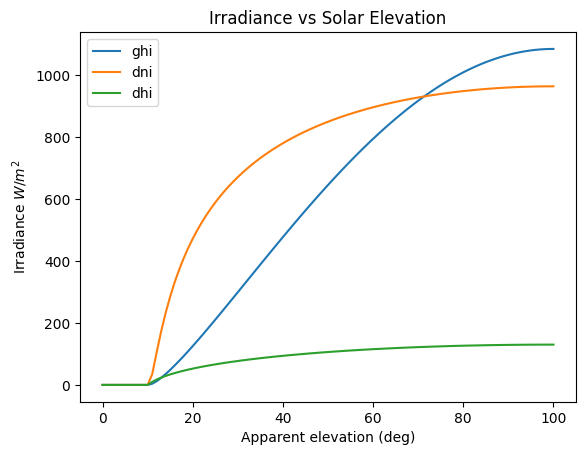

In [67]:
apparent_elevation = pd.Series(np.linspace(-10, 90, 101))

aod700 = 0.1

precipitable_water = 1

pressure = 101325

dni_extra = 1364

solis = clearsky.simplified_solis(apparent_elevation, aod700,
                                  precipitable_water, pressure, dni_extra)


ax = solis.plot();

ax.set_xlabel('Apparent elevation (deg)');

ax.set_ylabel('Irradiance $W/m^2$');

ax.set_title('Irradiance vs Solar Elevation')


ax.legend(loc=2);

Grid with clear sky irradiance for a few PW and AOD values.

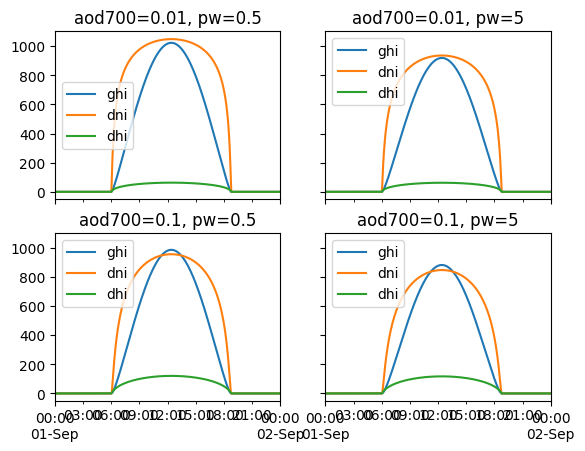

In [68]:
times = pd.date_range(start='2014-09-01', end='2014-09-02', freq='1Min', tz=tz)

solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)

apparent_elevation = solpos['apparent_elevation']

pressure = pvlib.atmosphere.alt2pres(altitude)

dni_extra = pvlib.irradiance.get_extra_radiation(times)

aod700 = [0.01, 0.1]

precipitable_water = [0.5, 5]

fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, squeeze=True)

axes = axes.flatten()

for (aod, pw), ax in zip(itertools.chain(itertools.product(aod700, precipitable_water)), axes):
    cs = clearsky.simplified_solis(apparent_elevation, aod, pw, pressure, dni_extra)
    cs.plot(ax=ax, title='aod700={}, pw={}'.format(aod, pw))

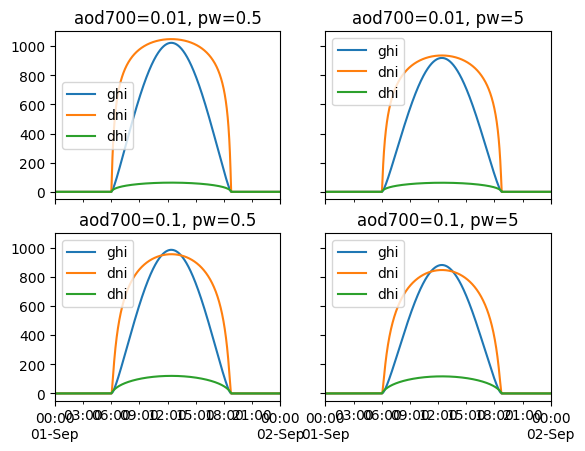

In [69]:
# times = pd.date_range(start='2014-09-01', end='2014-09-02', freq='1Min', tz=tz)
times_utc = pd.date_range(start='2014-09-01', end='2014-09-02', freq='1Min', tz=tz).tz_convert('utc')

# solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)
solpos_utc = pvlib.solarposition.get_solarposition(times_utc, latitude, longitude).tz_convert(tz)

# apparent_elevation = solpos['apparent_elevation']
apparent_elevation_utc = solpos_utc['apparent_elevation']

pressure = pvlib.atmosphere.alt2pres(altitude)

# dni_extra = pvlib.irradiance.get_extra_radiation(times)
dni_extra_utc = pvlib.irradiance.get_extra_radiation(times_utc).tz_convert(tz)

aod700 = [0.01, 0.1]

precipitable_water = [0.5, 5]

fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, squeeze=True)

axes = axes.flatten()

for (aod, pw), ax in zip(itertools.chain(itertools.product(aod700, precipitable_water)), axes):
    # cs = clearsky.simplified_solis(apparent_elevation, aod, pw, pressure, dni_extra)
    # cs.plot(ax=ax, title='aod700={}, pw={}'.format(aod, pw))
    cs_utc = clearsky.simplified_solis(apparent_elevation_utc.tz_convert('utc'), aod, pw, pressure, dni_extra_utc.tz_convert('utc')).tz_convert(tz)
    cs_utc2 = clearsky.simplified_solis(apparent_elevation_utc, aod, pw, pressure, dni_extra_utc)
    cs_utc.plot(ax=ax, title='aod700={}, pw={}'.format(aod, pw))

In [70]:
solpos.equals(solpos_utc)

True

In [71]:
assert dni_extra.index.equals(dni_extra_utc.index)
assert not ((dni_extra < 0).any() or (dni_extra_utc < 0).any())
print(len(dni_extra))
df = pd.concat([dni_extra, dni_extra_utc], axis = 'columns', join = 'outer')[~ dni_extra.fillna(-1).eq(dni_extra_utc.fillna(-1))]
print(df.index.hour.unique(), df.index.minute.nunique())
df

1441
Index([17, 18, 19, 20, 21, 22, 23], dtype='int32') 60


,0,1
2014-09-01 17:00:00-07:00,1340.74477,1341.396857
2014-09-01 17:01:00-07:00,1340.74477,1341.396857
2014-09-01 17:02:00-07:00,1340.74477,1341.396857
2014-09-01 17:03:00-07:00,1340.74477,1341.396857
2014-09-01 17:04:00-07:00,1340.74477,1341.396857
...,...,...
2014-09-01 23:55:00-07:00,1340.74477,1341.396857
2014-09-01 23:56:00-07:00,1340.74477,1341.396857
2014-09-01 23:57:00-07:00,1340.74477,1341.396857
2014-09-01 23:58:00-07:00,1340.74477,1341.396857


In [72]:
assert cs.index.equals(cs_utc.index)
assert not ((cs < 0).any().any() or (cs_utc < 0).any().any())
print(len(cs))
df = cs.join(cs_utc, how = 'outer', rsuffix = '_utc')[~ cs.fillna(-1).eq(cs_utc.fillna(-1)).all(axis = 'columns')]
print(df.index.hour.unique(), df.index.minute.nunique())
df

1441
Index([17, 18], dtype='int32') 60


,ghi,dni,dhi,ghi_utc,dni_utc,dhi_utc
2014-09-01 17:00:00-07:00,295.343846,607.599224,75.799706,295.487490,607.894738,75.836572
2014-09-01 17:01:00-07:00,291.936246,605.063062,75.434880,292.078233,605.357342,75.471569
2014-09-01 17:02:00-07:00,288.529050,602.498981,75.067291,288.669380,602.792014,75.103801
2014-09-01 17:03:00-07:00,285.122422,599.906516,74.696905,285.261095,600.198288,74.733235
2014-09-01 17:04:00-07:00,281.716530,597.285191,74.323688,281.853547,597.575688,74.359836
...,...,...,...,...,...,...
2014-09-01 18:42:00-07:00,2.192736,19.382360,7.879684,2.193802,19.391787,7.883516
2014-09-01 18:43:00-07:00,1.380682,11.496706,6.312305,1.381354,11.502297,6.315375
2014-09-01 18:44:00-07:00,0.735281,5.332957,4.673555,0.735639,5.335551,4.675828
2014-09-01 18:45:00-07:00,0.279197,1.445063,2.959966,0.279333,1.445766,2.961406


In [73]:
cs_utc.equals(cs_utc2)

True

Contour plots of irradiance as a function of both PW and AOD.

In [74]:
aod700 = np.linspace(0, 0.5, 101)

precipitable_water = np.linspace(0, 10, 101)

apparent_elevation = 70

pressure = 101325

dni_extra = 1364

aod700, precipitable_water = np.meshgrid(aod700, precipitable_water)


solis = clearsky.simplified_solis(apparent_elevation, aod700,
                                  precipitable_water, pressure,
                                  dni_extra)


n = 15

vmin = None

vmax = None

def plot_solis(key):
    irrad = solis[key]
    fig, ax = plt.subplots()
    im = ax.contour(aod700, precipitable_water, irrad[:, :], n, vmin=vmin, vmax=vmax)
    imf = ax.contourf(aod700, precipitable_water, irrad[:, :], n, vmin=vmin, vmax=vmax)
    ax.set_xlabel('AOD')
    ax.set_ylabel('Precipitable water (cm)')
    ax.clabel(im, colors='k', fmt='%.0f')
    fig.colorbar(imf, label='{} (W/m**2)'.format(key))
    ax.set_title('{}, elevation={}'.format(key, apparent_elevation))

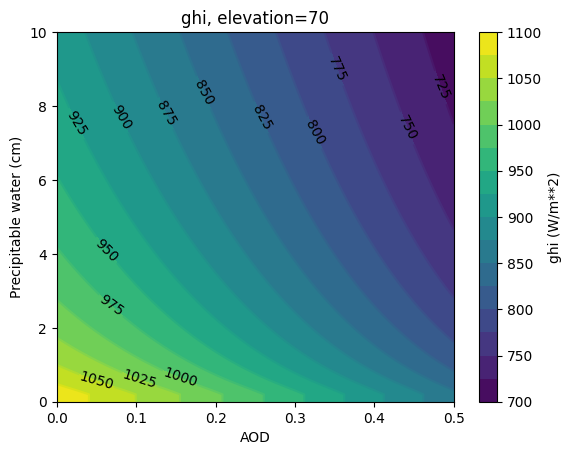

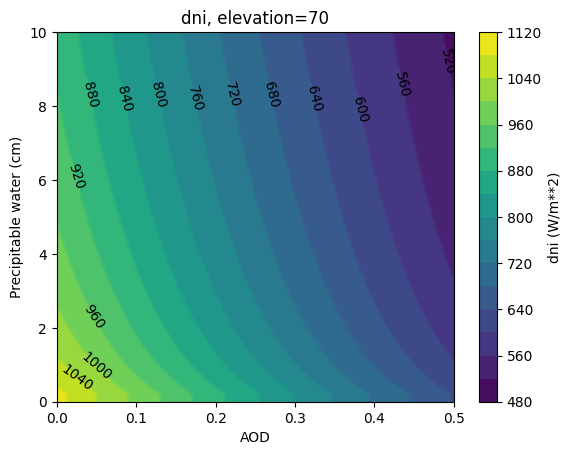

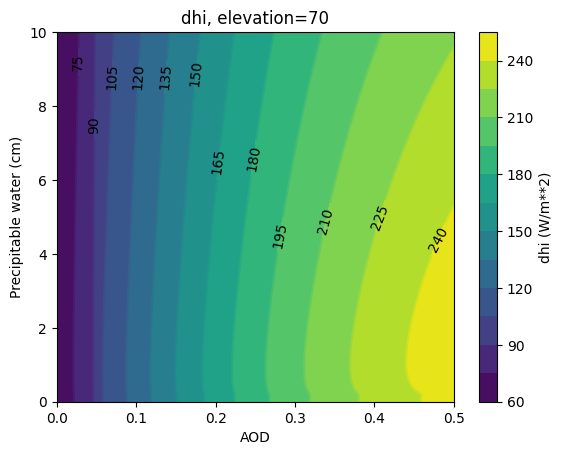

In [75]:
plot_solis('ghi')


plot_solis('dni')


plot_solis('dhi')

Validation
^^^^^^^^^^

See [Ine16]_.

Detect Clearsky
---------------

The :py:func:`~pvlib.clearsky.detect_clearsky` function implements the
[Ren16]_ algorithm to detect the clear and cloudy points of a time
series. The algorithm was designed and validated for analyzing GHI time
series only. Users may attempt to apply it to other types of time series
data using different filter settings, but should be skeptical of the
results.

The algorithm detects clear sky times by comparing statistics for a
measured time series and an expected clearsky time series. Statistics
are calculated using a sliding time window (e.g., 10 minutes). An
iterative algorithm identifies clear periods, uses the identified
periods to estimate bias in the clearsky data, scales the clearsky data
and repeats.

Clear times are identified by meeting 5 criteria. Default values for
these thresholds are appropriate for 10 minute windows of 1 minute GHI
data.

Next, we show a simple example of applying the algorithm to synthetic
GHI data. We first generate and plot the clear sky and measured data.


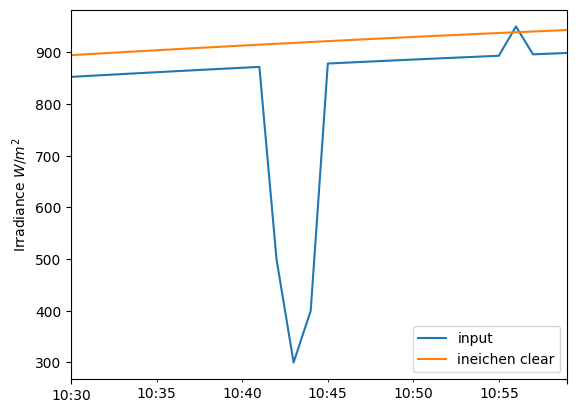

In [76]:
abq = Location(35.04, -106.62, altitude=1619)

times = pd.date_range(start='2012-04-01 10:30:00', tz='Etc/GMT+7', periods=30, freq='1min')

cs = abq.get_clearsky(times)


ghi = cs['ghi']*.953


ghi['2012-04-01 10:42:00':'2012-04-01 10:44:00'] = [500, 300, 400]


ghi['2012-04-01 10:56:00'] = 950

fig, ax = plt.subplots()

ghi.plot(label='input');

cs['ghi'].plot(label='ineichen clear');

ax.set_ylabel('Irradiance $W/m^2$');

plt.legend(loc=4);

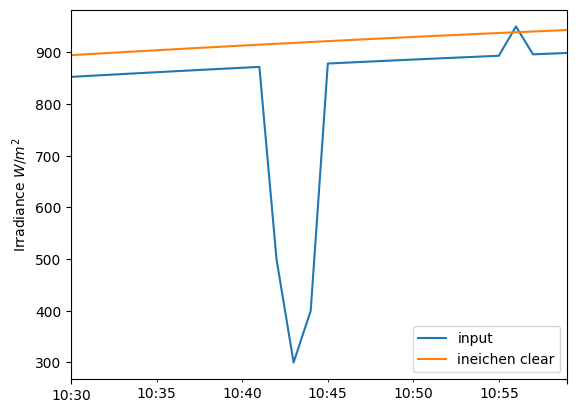

In [77]:
abq = Location(35.04, -106.62, altitude=1619)

# times = pd.date_range(start='2012-04-01 10:30:00', tz='Etc/GMT+7', periods=30, freq='1min')
times_utc = pd.date_range(start='2012-04-01 10:30:00', tz='Etc/GMT+7', periods=30, freq='1min').tz_convert('utc')

# cs = abq.get_clearsky(times)
cs_utc = abq.get_clearsky(times_utc).tz_convert(times.tz)


# ghi = cs['ghi']*.953
ghi_utc = cs_utc['ghi']*.953


# ghi['2012-04-01 10:42:00':'2012-04-01 10:44:00'] = [500, 300, 400]
ghi_utc['2012-04-01 10:42:00':'2012-04-01 10:44:00'] = [500, 300, 400]


# ghi['2012-04-01 10:56:00'] = 950
ghi_utc['2012-04-01 10:56:00'] = 950

fig, ax = plt.subplots()

# ghi.plot(label='input');
ghi_utc.plot(label='input');

# cs['ghi'].plot(label='ineichen clear');
cs_utc['ghi'].plot(label='ineichen clear');

ax.set_ylabel('Irradiance $W/m^2$');

plt.legend(loc=4);

In [78]:
cs.equals(cs_utc)

True

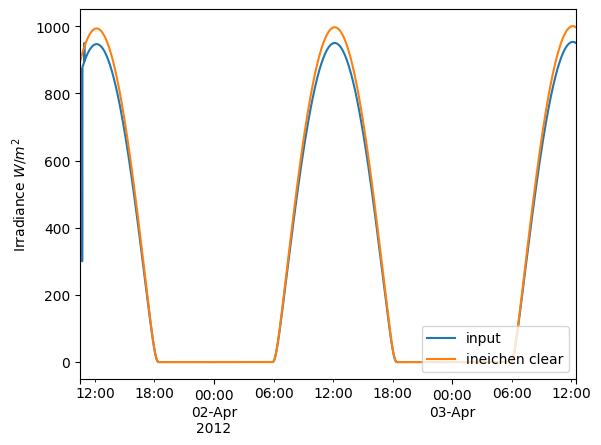

In [79]:
abq = Location(35.04, -106.62, altitude=1619)

# times = pd.date_range(start='2012-04-01 10:30:00', tz='Etc/GMT+7', periods=30, freq='1min')
times_3000 = pd.date_range(start='2012-04-01 10:30:00', tz='Etc/GMT+7', periods=3000, freq='1min')

# cs = abq.get_clearsky(times)
cs_3000 = abq.get_clearsky(times_3000)


# ghi = cs['ghi']*.953
ghi_3000 = cs_3000['ghi']*.953


# ghi['2012-04-01 10:42:00':'2012-04-01 10:44:00'] = [500, 300, 400]
ghi_3000['2012-04-01 10:42:00':'2012-04-01 10:44:00'] = [500, 300, 400]


# ghi['2012-04-01 10:56:00'] = 950
ghi_3000['2012-04-01 10:56:00'] = 950

fig, ax = plt.subplots()

# ghi.plot(label='input');
ghi_3000.plot(label='input');

# cs['ghi'].plot(label='ineichen clear');
cs_3000['ghi'].plot(label='ineichen clear');

ax.set_ylabel('Irradiance $W/m^2$');

plt.legend(loc=4);

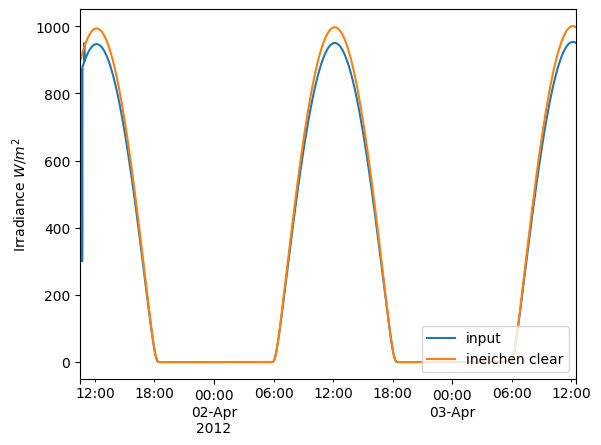

In [80]:
abq = Location(35.04, -106.62, altitude=1619)

# times = pd.date_range(start='2012-04-01 10:30:00', tz='Etc/GMT+7', periods=300, freq='1min')
times_3000_utc = pd.date_range(start='2012-04-01 10:30:00', tz='Etc/GMT+7', periods=3000, freq='1min').tz_convert('utc')

# cs = abq.get_clearsky(times)
cs_3000_utc = abq.get_clearsky(times_3000_utc).tz_convert(times.tz)


# ghi = cs['ghi']*.953
ghi_3000_utc = cs_3000_utc['ghi']*.953


# ghi['2012-04-01 10:42:00':'2012-04-01 10:44:00'] = [500, 300, 400]
ghi_3000_utc['2012-04-01 10:42:00':'2012-04-01 10:44:00'] = [500, 300, 400]


# ghi['2012-04-01 10:56:00'] = 950
ghi_3000_utc['2012-04-01 10:56:00'] = 950

fig, ax = plt.subplots()

# ghi.plot(label='input');
ghi_3000_utc.plot(label='input');

# cs['ghi'].plot(label='ineichen clear');
cs_3000_utc['ghi'].plot(label='ineichen clear');

ax.set_ylabel('Irradiance $W/m^2$');

plt.legend(loc=4);

In [81]:
assert cs_3000.index.equals(cs_3000_utc.index)
assert not ((cs_3000 < 0).any().any() or (cs_3000_utc < 0).any().any())
print(len(cs_3000))
df = cs_3000.join(cs_3000_utc, how = 'outer', rsuffix = '_utc')[~ cs_3000.fillna(-1).eq(cs_3000_utc.fillna(-1)).all(axis = 'columns')]
print(df.index.hour.unique(), df.index.minute.nunique())
df

3000
Index([17, 18], dtype='int32') 60


,ghi,dni,dhi,ghi_utc,dni_utc,dhi_utc
2012-04-01 17:00:00-07:00,269.377851,783.351411,37.325921,269.082874,781.619230,37.544068
2012-04-01 17:01:00-07:00,265.228077,779.728342,36.888553,264.936135,777.989910,37.105701
2012-04-01 17:02:00-07:00,261.078198,776.036005,36.450018,260.789301,774.291271,36.666145
2012-04-01 17:03:00-07:00,256.928488,772.272561,36.010310,256.642650,770.521475,36.225391
2012-04-01 17:04:00-07:00,252.779232,768.436109,35.569420,252.496464,766.678623,35.783431
...,...,...,...,...,...,...
2012-04-02 18:23:00-07:00,0.794875,34.560954,0.341981,0.790978,34.063517,0.344603
2012-04-02 18:24:00-07:00,0.490995,27.294763,0.219836,0.488447,26.876910,0.221439
2012-04-02 18:25:00-07:00,0.268592,21.097785,0.125223,0.267114,20.753738,0.126083
2012-04-02 18:26:00-07:00,0.114240,15.938055,0.055480,0.113572,15.660838,0.055834


Now we run the synthetic data and clear sky estimate through the
:py:func:`~pvlib.clearsky.detect_clearsky` function.

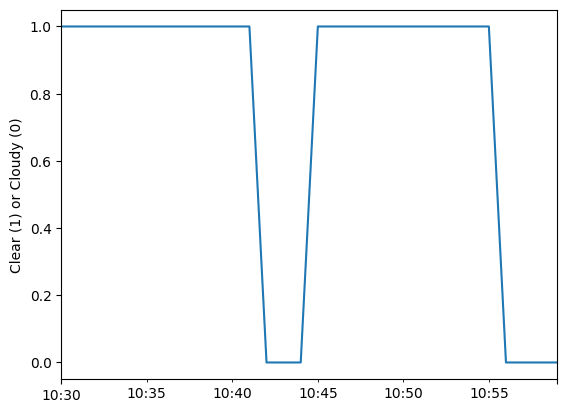

In [82]:
clear_samples = clearsky.detect_clearsky(ghi, cs['ghi'])

fig, ax = plt.subplots()

clear_samples.astype(int).plot();

ax.set_ylabel('Clear (1) or Cloudy (0)');

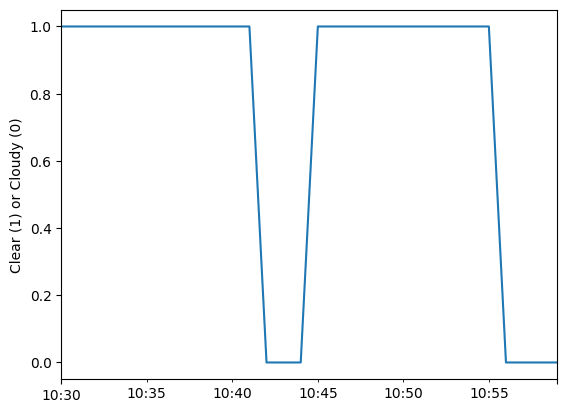

In [83]:
# clear_samples = clearsky.detect_clearsky(ghi, cs['ghi'])
clear_samples_utc = clearsky.detect_clearsky(ghi_utc, cs_utc['ghi'])

fig, ax = plt.subplots()

# clear_samples.astype(int).plot();
clear_samples_utc.astype(int).plot();

ax.set_ylabel('Clear (1) or Cloudy (0)');

In [84]:
clear_samples.equals(clear_samples_utc)

True

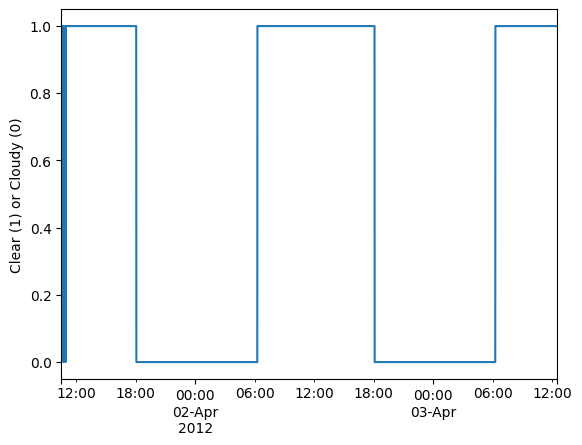

In [85]:
# clear_samples = clearsky.detect_clearsky(ghi, cs['ghi'])
clear_samples_3000 = clearsky.detect_clearsky(ghi_3000, cs_3000['ghi'])

fig, ax = plt.subplots()

# clear_samples.astype(int).plot();
clear_samples_3000.astype(int).plot();

ax.set_ylabel('Clear (1) or Cloudy (0)');

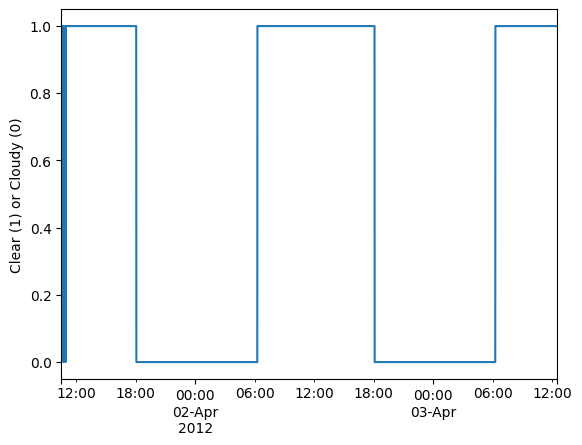

In [86]:
# clear_samples = clearsky.detect_clearsky(ghi, cs['ghi'])
clear_samples_3000_utc = clearsky.detect_clearsky(ghi_3000_utc, cs_3000_utc['ghi'])

fig, ax = plt.subplots()

# clear_samples.astype(int).plot();
clear_samples_3000_utc.astype(int).plot();

ax.set_ylabel('Clear (1) or Cloudy (0)');

In [87]:
clear_samples_3000.equals(clear_samples_3000_utc)

True

The algorithm detected the cloud event and the overirradiance event.

References
----------

.. [Ine02] P. Ineichen and R. Perez, "A New airmass independent formulation for
   the Linke turbidity coefficient", Solar Energy, 73, pp. 151-157,
   2002.

.. [Ine08ss] P. Ineichen, "A broadband simplified version of the
   Solis clear sky model," Solar Energy, 82, 758-762 (2008).

.. [Ine16] P. Ineichen, "Validation of models that estimate the clear
   sky global and beam solar irradiance," Solar Energy, 132,
   332-344 (2016).

.. [Ine08con] P. Ineichen, "Conversion function between the Linke turbidity
   and the atmospheric water vapor and aerosol content", Solar Energy,
   82, 1095 (2008).

.. [Ren12] M. Reno, C. Hansen, and J. Stein, "Global Horizontal Irradiance Clear
   Sky Models: Implementation and Analysis", Sandia National
   Laboratories, SAND2012-2389, 2012.

.. [Ren16] Reno, M.J. and C.W. Hansen, "Identification of periods of clear
   sky irradiance in time series of GHI measurements" Renewable Energy,
   v90, p. 520-531, 2016.

.. [Mol98] B. Molineaux, P. Ineichen, and N. O’Neill, “Equivalence of
   pyrheliometric and monochromatic aerosol optical depths at a single key
   wavelength.,” Appl. Opt., vol. 37, no. 30, pp. 7008–18, Oct. 1998.

.. [Kas96] F. Kasten, “The linke turbidity factor based on improved values
   of the integral Rayleigh optical thickness,” Sol. Energy, vol. 56, no. 3,
   pp. 239–244, Mar. 1996.

.. [Bir80] R. E. Bird and R. L. Hulstrom, “Direct Insolation Models,”
   1980.

.. [Ang61] A. ÅNGSTRÖM, “Techniques of Determinig the Turbidity of the
   Atmosphere,” Tellus A, vol. 13, no. 2, pp. 214–223, 1961.
